<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_9/Aula_9_Inpairs_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'
print(f'Meu nome é {nome}')

Meu nome é Leonardo Augusto da Silva Pacheco


# Enunciado

https://github.com/leonardo3108/IA368dd/blob/main/exercicios/Aula_9/enunciado.md

# Setup

## Integração com Google Drive

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Hiperparâmetros

In [2]:
model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
max_seq_length = 512
batch_size = 16
lr = 5e-5
epochs=20
model_save_dir = 'model_save'

## Preparação das pastas

In [3]:
!mkdir $model_save_dir

## Instalação de libs

In [4]:
!pip install huggingface_hub 
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

## Importação de libs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

import datasets
import json
import os
import torch

from huggingface_hub import login
from pathlib import Path
from statistics import mean
from torch.utils import data
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AdamW, AutoModelForSequenceClassification, AutoTokenizer, BatchEncoding, get_linear_schedule_with_warmup

## Login na Hugging Face

In [6]:
login()

## Utilização de GPUs

In [13]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [14]:
if dev != 'cpu':
    !nvidia-smi

Thu May  4 13:13:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção - TREC-COVID

In [15]:
!wget -nc 'https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip'

File ‘trec-covid.zip’ already there; not retrieving.



In [16]:
!unzip -o trec-covid.zip

Archive:  trec-covid.zip
  inflating: trec-covid/qrels/test.tsv  
  inflating: trec-covid/corpus.jsonl  
  inflating: trec-covid/queries.jsonl  


## Tratamento - corpus

In [17]:
corpus = {}
with open('trec-covid/corpus.jsonl') as fin:
    for i, line in enumerate(fin):
        doc = json.loads(line)
        corpus[doc['_id']] = f"{doc['title']} {doc['text']}"

for id in list(corpus.keys())[:10]:
    print(id + ':', corpus[id])

ug7v899j: Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumon

## Obtenção - exemplos

In [18]:
dataset_experiment = datasets.load_dataset('unicamp-dl/trec-covid-experiment')
dataset_experiment

Generating example split: 0 examples [00:00, ? examples/s]

Generating example2 split: 0 examples [00:00, ? examples/s]

Generating eduseiti_100_queries_expansion_20230501_01 split: 0 examples [00:00, ? examples/s]

Generating leandro_carisio_01 split: 0 examples [00:00, ? examples/s]

Generating thales_1k_generated_queries_20230429 split: 0 examples [00:00, ? examples/s]

Generating manoel_1k_generated_queries_20230430 split: 0 examples [00:00, ? examples/s]

Generating manoel_2k_generated_queries_20230501 split: 0 examples [00:00, ? examples/s]

Generating thiago_laitz_1k_queries split: 0 examples [00:00, ? examples/s]

Generating mirelle_1k_generated_queries_20230501 split: 0 examples [00:00, ? examples/s]

Generating hugo_padovani_query_generation split: 0 examples [00:00, ? examples/s]

Generating marcus_borela_1k_gptj6b_20230501 split: 0 examples [00:00, ? examples/s]

Generating juliatessler_1000_queries split: 0 examples [00:00, ? examples/s]

Generating pedro_holanda_1k_generated_queries_20230502 split: 0 examples [00:00, ? examples/s]

Generating leonardo_avila_queries_v1 split: 0 examples [00:00, ? examples/s]

Generating marcus_borela_1k_gptj6b_20230501_v2 split: 0 examples [00:00, ? examples/s]

Generating gustavo_1k_cohere split: 0 examples [00:00, ? examples/s]

Generating marcospiau_1k_v1 split: 0 examples [00:00, ? examples/s]

Generating pedrogengo_queries_inparsv1 split: 0 examples [00:00, ? examples/s]

Generating ricardo_primi_1k split: 0 examples [00:00, ? examples/s]

Generating thiago_vieira_1k_queries split: 0 examples [00:00, ? examples/s]

Generating eduseiti_1000_queries_expansion_20230502_02 split: 0 examples [00:00, ? examples/s]

Dataset trec-covid-experiment downloaded and prepared to /root/.cache/huggingface/datasets/unicamp-dl___trec-covid-experiment/default/0.0.0/5dba10045db0dc33df357c18a85d3803a49c453a7eeb9daac832882e92fc5d79. Subsequent calls will reuse this data.


  0%|          | 0/21 [00:00<?, ?it/s]

DatasetDict({
    example: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    example2: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    eduseiti_100_queries_expansion_20230501_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 463
    })
    leandro_carisio_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1001
    })
    thales_1k_generated_queries_20230429: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_1k_generated_queries_20230430: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_2k_generated_queries_20230501: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 2000
    })
    thiago_l

## Tratamento - exemplos

### Criação do Dataframe

In [19]:
df = pd.concat((v.to_pandas().assign(origin=k) for k,v in dataset_experiment.items()), ignore_index=True)
df

,query,positive_doc_id,negative_doc_ids,origin
0,This is a example query 1,doc1,"[xxx, yyy, zzz]",example
1,This is another example query,doc2,"[aaa, bbb, ccc]",example
2,Example of query with no negative doc_ids,doc2,[],example
3,This is a example query 1 (file 2),doc12222,"[xxx, yyy, zzz]",example2
4,This is another example query (file 2),doc12345,"[aaa, bbb, ccc]",example2
...,...,...,...,...
23586,What is the role of GBF1 in poliovirus replica...,lxb2otpr,"[h2cm3cge, d441jam3, 3kmqy07w, tg0tczni, j6zir...",eduseiti_1000_queries_expansion_20230502_02
23587,How does the presence of BFA affect polio repl...,lxb2otpr,"[0u62j7nj, 8jnrc01n, k9dl79kc, jc4ckqy7, c3g3h...",eduseiti_1000_queries_expansion_20230502_02
23588,Does the N-terminus domain of GBF1 have any ro...,lxb2otpr,"[3jxi0dj2, bpnqz1cn, pujlr8uf, ywanv2la, u9u0y...",eduseiti_1000_queries_expansion_20230502_02
23589,How does the absence of p115 and Rab1b influen...,lxb2otpr,"[dcmz4wcn, 413m7czk, qnntyqud, 8ut2p9p6, 5gp8w...",eduseiti_1000_queries_expansion_20230502_02


### Remoção dos registros de exemplo

In [20]:
df.groupby(['origin']).count()['query']

origin
eduseiti_1000_queries_expansion_20230502_02    4914
eduseiti_100_queries_expansion_20230501_01      463
example                                           3
example2                                          3
gustavo_1k_cohere                              1000
hugo_padovani_query_generation                  979
juliatessler_1000_queries                      1000
leandro_carisio_01                             1001
leonardo_avila_queries_v1                       996
manoel_1k_generated_queries_20230430           1000
manoel_2k_generated_queries_20230501           2000
marcospiau_1k_v1                               1000
marcus_borela_1k_gptj6b_20230501               1000
marcus_borela_1k_gptj6b_20230501_v2            1000
mirelle_1k_generated_queries_20230501           999
pedro_holanda_1k_generated_queries_20230502    1088
pedrogengo_queries_inparsv1                    1146
ricardo_primi_1k                                999
thales_1k_generated_queries_20230429           1000
thiag

In [21]:
df = df.query("origin != 'example' and origin != 'example2'")
df

,query,positive_doc_id,negative_doc_ids,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,"[mt00852w, x7ol32mz, b54dymlu, h5vh6px7, bza9a...",eduseiti_100_queries_expansion_20230501_01
7,What strategies can be used to encourage desir...,70hskj1o,"[et84j0qi, xsfolppr, 5t2o287y, kj2tnw8q, j68x0...",eduseiti_100_queries_expansion_20230501_01
8,What are the risks associated with amplifying ...,70hskj1o,"[2c1m04je, rd93y7hu, vlmvi0tf, dbq3z982, 848fs...",eduseiti_100_queries_expansion_20230501_01
9,What research has been conducted on the effect...,70hskj1o,"[49zlztqu, amjqr9hr, hpx4723v, e790rxq9, 95bso...",eduseiti_100_queries_expansion_20230501_01
10,How can collaborations between healthcare work...,70hskj1o,"[eg2lj9zc, prmf9yob, ara8bsws, zjmshwl3, apvc5...",eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
23586,What is the role of GBF1 in poliovirus replica...,lxb2otpr,"[h2cm3cge, d441jam3, 3kmqy07w, tg0tczni, j6zir...",eduseiti_1000_queries_expansion_20230502_02
23587,How does the presence of BFA affect polio repl...,lxb2otpr,"[0u62j7nj, 8jnrc01n, k9dl79kc, jc4ckqy7, c3g3h...",eduseiti_1000_queries_expansion_20230502_02
23588,Does the N-terminus domain of GBF1 have any ro...,lxb2otpr,"[3jxi0dj2, bpnqz1cn, pujlr8uf, ywanv2la, u9u0y...",eduseiti_1000_queries_expansion_20230502_02
23589,How does the absence of p115 and Rab1b influen...,lxb2otpr,"[dcmz4wcn, 413m7czk, qnntyqud, 8ut2p9p6, 5gp8w...",eduseiti_1000_queries_expansion_20230502_02


### Limita a 5 exemplos negativos

In [22]:
df['negative_doc_ids'] = df['negative_doc_ids'].map(lambda vec: vec[0:5])
df

<ipython-input-22-bbab50e2d658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative_doc_ids'] = df['negative_doc_ids'].map(lambda vec: vec[0:5])


,query,positive_doc_id,negative_doc_ids,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,"[mt00852w, x7ol32mz, b54dymlu, h5vh6px7, bza9a...",eduseiti_100_queries_expansion_20230501_01
7,What strategies can be used to encourage desir...,70hskj1o,"[et84j0qi, xsfolppr, 5t2o287y, kj2tnw8q, j68x0...",eduseiti_100_queries_expansion_20230501_01
8,What are the risks associated with amplifying ...,70hskj1o,"[2c1m04je, rd93y7hu, vlmvi0tf, dbq3z982, 848fs...",eduseiti_100_queries_expansion_20230501_01
9,What research has been conducted on the effect...,70hskj1o,"[49zlztqu, amjqr9hr, hpx4723v, e790rxq9, 95bso...",eduseiti_100_queries_expansion_20230501_01
10,How can collaborations between healthcare work...,70hskj1o,"[eg2lj9zc, prmf9yob, ara8bsws, zjmshwl3, apvc5...",eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
23586,What is the role of GBF1 in poliovirus replica...,lxb2otpr,"[h2cm3cge, d441jam3, 3kmqy07w, tg0tczni, j6zir...",eduseiti_1000_queries_expansion_20230502_02
23587,How does the presence of BFA affect polio repl...,lxb2otpr,"[0u62j7nj, 8jnrc01n, k9dl79kc, jc4ckqy7, c3g3h...",eduseiti_1000_queries_expansion_20230502_02
23588,Does the N-terminus domain of GBF1 have any ro...,lxb2otpr,"[3jxi0dj2, bpnqz1cn, pujlr8uf, ywanv2la, u9u0y...",eduseiti_1000_queries_expansion_20230502_02
23589,How does the absence of p115 and Rab1b influen...,lxb2otpr,"[dcmz4wcn, 413m7czk, qnntyqud, 8ut2p9p6, 5gp8w...",eduseiti_1000_queries_expansion_20230502_02


### Muda estrutura - 1 registro por exemplo

- explode expande a lista de exemplos negativos
- melt separa exemplo positivo de negativo
- drop_duplicates remove as duplicatas

In [23]:
df.rename(columns={'positive_doc_id': '1', 'negative_doc_ids': '0'}, inplace=True)

<ipython-input-23-35d02e369c87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'positive_doc_id': '1', 'negative_doc_ids': '0'}, inplace=True)


In [24]:
df = df.explode('0')
df

,query,1,0,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,mt00852w,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,x7ol32mz,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,b54dymlu,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,h5vh6px7,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,bza9agzo,eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
23590,Does the Sec7 domain of GBF1 contribute to pol...,lxb2otpr,0gtm5ose,eduseiti_1000_queries_expansion_20230502_02
23590,Does the Sec7 domain of GBF1 contribute to pol...,lxb2otpr,ixnafpv7,eduseiti_1000_queries_expansion_20230502_02
23590,Does the Sec7 domain of GBF1 contribute to pol...,lxb2otpr,4mnaicki,eduseiti_1000_queries_expansion_20230502_02
23590,Does the Sec7 domain of GBF1 contribute to pol...,lxb2otpr,sgjnb8qc,eduseiti_1000_queries_expansion_20230502_02


In [25]:
df = pd.melt(df, id_vars=['query', 'origin'], value_vars=['0', '1'])
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
218665,Does the Sec7 domain of GBF1 contribute to pol...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218666,Does the Sec7 domain of GBF1 contribute to pol...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218667,Does the Sec7 domain of GBF1 contribute to pol...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218668,Does the Sec7 domain of GBF1 contribute to pol...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr


In [26]:
df = df.drop_duplicates()
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
218645,What is the role of GBF1 in poliovirus replica...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218650,How does the presence of BFA affect polio repl...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218655,Does the N-terminus domain of GBF1 have any ro...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218660,How does the absence of p115 and Rab1b influen...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr


In [27]:
df = df[df['value'].notnull()]
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
218645,What is the role of GBF1 in poliovirus replica...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218650,How does the presence of BFA affect polio repl...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218655,Does the N-terminus domain of GBF1 have any ro...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218660,How does the absence of p115 and Rab1b influen...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr


### Renomeia colunas 
- para labels esperados no treinamento

In [28]:
df.rename(columns={'variable': 'label', 'value': 'doc_id'}, inplace=True)
df

<ipython-input-28-115ae39608f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'variable': 'label', 'value': 'doc_id'}, inplace=True)


,query,origin,label,doc_id
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
218645,What is the role of GBF1 in poliovirus replica...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218650,How does the presence of BFA affect polio repl...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218655,Does the N-terminus domain of GBF1 have any ro...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr
218660,How does the absence of p115 and Rab1b influen...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr


## Dados de exemplos com textos

In [29]:
df['text'] = df['doc_id'].map(lambda id: corpus[id])
df

<ipython-input-29-969372dd1c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['doc_id'].map(lambda id: corpus[id])


,query,origin,label,doc_id,text
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w,You Need a Plan: A Stepwise Protocol for Opera...
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz,Prenatal Care Redesign: Creating Flexible Mate...
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu,Impact of COVID-19 on maxillofacial surgery pr...
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7,Spine Surgical Procedures during Coronavirus D...
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo,A systematic review of the smartphone applicat...
...,...,...,...,...,...
218645,What is the role of GBF1 in poliovirus replica...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr,Poliovirus Replication Requires the N-terminus...
218650,How does the presence of BFA affect polio repl...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr,Poliovirus Replication Requires the N-terminus...
218655,Does the N-terminus domain of GBF1 have any ro...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr,Poliovirus Replication Requires the N-terminus...
218660,How does the absence of p115 and Rab1b influen...,eduseiti_1000_queries_expansion_20230502_02,1,lxb2otpr,Poliovirus Replication Requires the N-terminus...


## Split treinamento e validação

In [30]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,query,origin,label,doc_id,text
0,What was the objective of the Boston Medical C...,juliatessler_1000_queries,0,qc6zx0x9,Experiences and Insights from the Early US COV...
1,what is the relationship between antifragility...,gustavo_1k_cohere,0,pfryji0y,Response to 'What does monitoring platelet cou...
2,How long ago did the development of IgG produc...,leonardo_avila_queries_v1,0,coesfldm,Trans-inhibition of HIV-1 by a long hairpin RN...
3,What is the significance of higher increases i...,marcus_borela_1k_gptj6b_20230501,1,16owrk68,Increase in cerebral oxygenation during advanc...
4,What is the sensitivity and detection limit of...,hugo_padovani_query_generation,0,7n4cvgs4,Quantitative assay for measuring the Taura syn...
...,...,...,...,...,...
131872,Was the effectiveness of Dichloroflavan tested...,leonardo_avila_queries_v1,0,7m48izpw,Virus‐provoked rhinitis and asthma in allergic...
131873,What is the name of the capital city of France?\n,thales_1k_generated_queries_20230429,1,38483aw1,Performance measures for upper gastrointestina...
131874,What is the role of poliovirus 2A(pro) in abro...,leonardo_avila_queries_v1,1,wzwpyvll,The Multifaceted Poliovirus 2A Protease: Regul...
131875,What are the potential benefits of using HER2-...,eduseiti_1000_queries_expansion_20230502_02,0,e7vwyv2a,Microbiota epitope similarity either dampens o...


In [31]:
valid_size = len(df) // 10
df_train = df.iloc[:-valid_size]
df_train

,query,origin,label,doc_id,text
0,What was the objective of the Boston Medical C...,juliatessler_1000_queries,0,qc6zx0x9,Experiences and Insights from the Early US COV...
1,what is the relationship between antifragility...,gustavo_1k_cohere,0,pfryji0y,Response to 'What does monitoring platelet cou...
2,How long ago did the development of IgG produc...,leonardo_avila_queries_v1,0,coesfldm,Trans-inhibition of HIV-1 by a long hairpin RN...
3,What is the significance of higher increases i...,marcus_borela_1k_gptj6b_20230501,1,16owrk68,Increase in cerebral oxygenation during advanc...
4,What is the sensitivity and detection limit of...,hugo_padovani_query_generation,0,7n4cvgs4,Quantitative assay for measuring the Taura syn...
...,...,...,...,...,...
118685,What is the difference between Human Parechovi...,eduseiti_1000_queries_expansion_20230502_02,0,7zjje146,Active surveillance of acute paediatric hospit...
118686,What are some methods of non-parenteral drug d...,eduseiti_1000_queries_expansion_20230502_02,0,e4vsj67u,Capter 11 Filtering in Drug Discovery Publishe...
118687,What are the clinical signs of the Shasta Rive...,eduseiti_1000_queries_expansion_20230502_02,0,8vljd5cv,Protection conferred by live infectious bronch...
118688,what was the purpose of the study comparing am...,thiago_laitz_1k_queries,0,qyyy4cdm,Epimedium koreanum Nakai Displays Broad Spectr...


In [32]:
df_valid = df.iloc[-valid_size:]
df_valid

,query,origin,label,doc_id,text
118690,What is the potential use of PARP inhibitors i...,pedrogengo_queries_inparsv1,1,adramg2a,Poly(ADP-ribose) Polymerase Inhibition in Acut...
118691,"""What are the justifications for non-consensua...",thiago_vieira_1k_queries,0,wrh0dz14,Cognitive rehabilitation in the elderly: effec...
118692,How effective is the interferon assay in detec...,leandro_carisio_01,0,n0acj460,Antiviral strategies for hepatitis E virus Abs...
118693,"What is NMODL, a new code generation framework...",manoel_1k_generated_queries_20230430,0,dcjwfes7,Development of an optimized RNA-based murine n...
118694,What is the estimated time-delay adjusted risk...,eduseiti_100_queries_expansion_20230501_01,0,e6k1bp9n,Analysis of Austrian COVID-19 deaths by age an...
...,...,...,...,...,...
131872,Was the effectiveness of Dichloroflavan tested...,leonardo_avila_queries_v1,0,7m48izpw,Virus‐provoked rhinitis and asthma in allergic...
131873,What is the name of the capital city of France?\n,thales_1k_generated_queries_20230429,1,38483aw1,Performance measures for upper gastrointestina...
131874,What is the role of poliovirus 2A(pro) in abro...,leonardo_avila_queries_v1,1,wzwpyvll,The Multifaceted Poliovirus 2A Protease: Regul...
131875,What are the potential benefits of using HER2-...,eduseiti_1000_queries_expansion_20230502_02,0,e7vwyv2a,Microbiota epitope similarity either dampens o...


In [33]:
print(df.label.value_counts())
print(df_train.label.value_counts())
print(df_valid.label.value_counts())

0    108297
1     23580
Name: label, dtype: int64
0    97444
1    21246
Name: label, dtype: int64
0    10853
1     2334
Name: label, dtype: int64


In [34]:
print(df.label.value_counts())
print(df_train.label.value_counts())
print(df_valid.label.value_counts())

0    108297
1     23580
Name: label, dtype: int64
0    97444
1    21246
Name: label, dtype: int64
0    10853
1     2334
Name: label, dtype: int64


## Tokenizer e Datasets

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [36]:
class Dataset(data.Dataset):
    def __init__(self, tokenizer, df, max_seq_length):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.input_text = (df['query'] + ' [SEP] ' + df['text']).tolist()
        self.labels = [float(x) for x in df['label'].tolist()]

    def __len__(self):
        return len(self.input_text)
    
    def get_sentence_mask(self, input_ids):
        sep_pos = input_ids.index(102) + 1
        seq_len = len(input_ids)
        return [0] * sep_pos + [1] * (seq_len - sep_pos)

    def __getitem__(self, idx):
        input = self.tokenizer(self.input_text[idx], padding='max_length', truncation=True, max_length=self.max_seq_length)
        input['labels'] = self.labels[idx]
        if isinstance(idx, slice):
            input['token_type_ids'] = [self.get_sentence_mask(input['input_ids'][i]) for i in range(idx.start or 0, idx.stop or len(input['input_ids']), idx.step or 1)]
        else:
            input['token_type_ids'] = self.get_sentence_mask(input['input_ids'])
        return input

In [37]:
dataset_train = Dataset(tokenizer, df_train, max_seq_length)
dataset_valid = Dataset(tokenizer, df_valid, max_seq_length)

## Collate e Dataloaders

In [38]:
collate_fn = lambda batch: BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

In [39]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Treinamento

## Preparação

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

def evaluate(model, dataloader, metrics):
    losses = []
    correct = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, mininterval=0.5, desc='Validation', disable=False):
            outputs = model(**batch.to(device))
            loss_val = outputs.loss
            losses.append(loss_val.cpu().item())
            preds = torch.round(torch.sigmoid(outputs.logits))
            correct += (preds.squeeze() == batch['labels']).sum().item()
    batch_loss = mean(losses)
    accuracy = correct / len(dataloader.dataset)
    print(f'Validation loss: {batch_loss:0.3f}; accuracy: {accuracy:0.3f}')
    if metrics:
        metrics['val_loss'].append(batch_loss)
        metrics['accuracy'].append(accuracy)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Execução

In [41]:
num_training_steps = epochs * len(dataloader_train)
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'accuracy': []}
evaluate(model, dataloader_valid, None)

for epoch in tqdm(range(0, epochs), desc='Epochs'):
    model.train()
    train_losses = []
    for batch in tqdm(dataloader_train, mininterval=0.5, desc='Train', disable=False):
        optimizer.zero_grad()
        outputs = model(**batch.to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.cpu().item())

    batch_loss = mean(train_losses)
    print(f'Epoch: {epoch + 1} Training loss: {batch_loss:0.2f}')
    metrics['train_loss'].append(batch_loss)

    save_path=Path(model_save_dir, "train", f"epoch_{epoch}")
    os.makedirs(save_path.parent, exist_ok=True)
    model.save_pretrained(save_path)
    
    evaluate(model, dataloader_valid, metrics)

Validation:   0%|          | 0/825 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation loss: 43.139; accuracy: 0.842


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 1 Training loss: 1.87


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.047; accuracy: 0.477


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 2 Training loss: 0.02


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.014; accuracy: 0.186


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 3 Training loss: 0.01


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.014; accuracy: 0.952


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 4 Training loss: 0.01


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.971


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 5 Training loss: 0.01


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.961


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 6 Training loss: 0.01


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.958


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 7 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.977


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 8 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.973


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 9 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.979


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 10 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.979


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 11 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.965


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 12 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.984


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 13 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.014; accuracy: 0.274


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 14 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.010; accuracy: 0.963


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 15 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.981


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 16 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.916


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 17 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.785


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 18 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.927


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 19 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.967


Train:   0%|          | 0/7419 [00:00<?, ?it/s]

Epoch: 20 Training loss: 0.00


Validation:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.982


## Avaliação - Visualização 

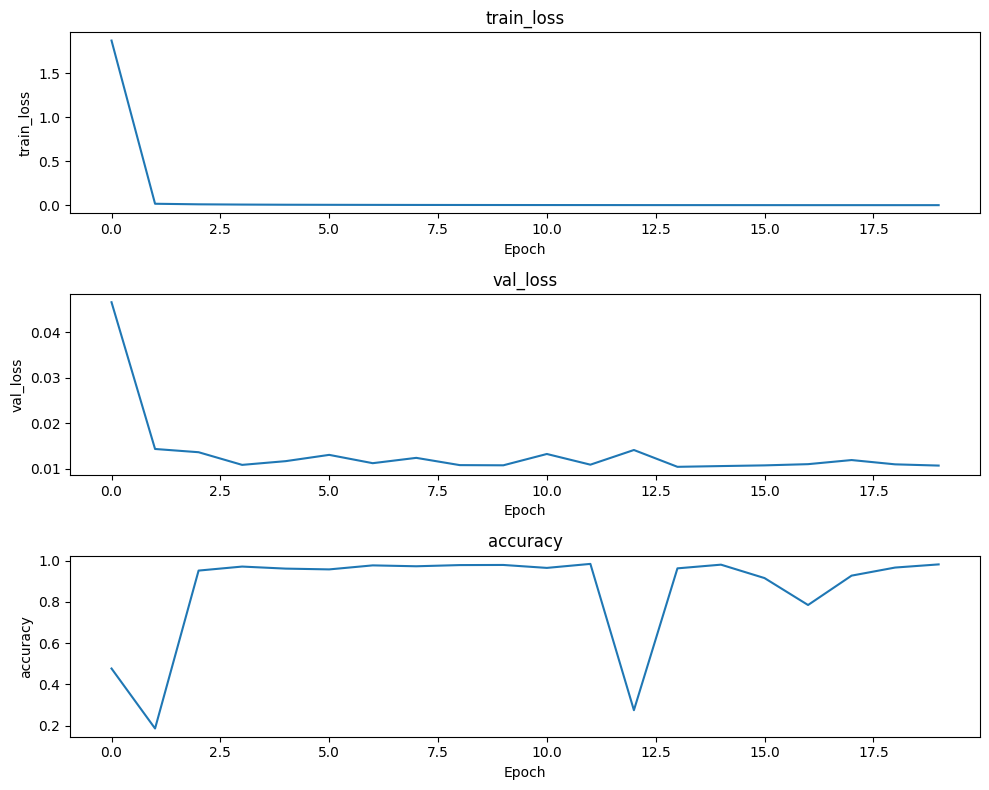

In [42]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics.keys()):
    axs[i].plot(metrics[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()

In [44]:
!cp model_save/train/epoch_11/* drive/MyDrive/temp/